In [2]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.model_selection import KFold
import numpy as np

d:\Users\herna\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\Users\herna\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
class SpectroCNN(nn.Module):
    def __init__(self):
        super(SpectroCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 2)  # 2 clases: Depresivo y No Depresivo
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.leaky_relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [10]:
# mport train
df_train = pd.read_csv('D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv('D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/test_split_Depression_AVEC2017.csv')
df_test_full = pd.read_csv('D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/full_test_split.csv')
df_dev = pd.read_csv('D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/dev_split_Depression_AVEC2017.csv')

In [11]:
# See head
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,307,0,4,0,0,1,0,1,0,2,0,0
2,331,0,8,1,1,1,1,1,1,1,1,1
3,335,1,12,0,1,1,3,2,3,1,1,0
4,346,1,23,0,2,3,3,3,3,3,3,3


In [12]:
df_test['Participant_ID'] = df_test['participant_ID']
df_test.drop('participant_ID', axis=1, inplace=True)

In [13]:
# Check if all data seems ok
print(df_train.shape[0], df_test_full.shape[0], df_dev.shape[0], df_train.shape[0]+ df_test_full.shape[0]+ df_dev.shape[0])

107 47 35 189


In [40]:
import os
import imageio
import pandas as pd
import numpy as np

def load_spectrogram(df):
    # Define root path of data
    root_path = 'D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/data'  # Replace with your root path

    # Add the column for spectrogram if it doesn't exist
    if 'Spectrogram' not in df.columns:
        # Define the shape of the fixed tensor
        tensor_shape = (292, 252, 3)  # Example shape (height, width, channels)

        # Create a fixed tensor of zeros with the desired shape
        fixed_tensor = np.zeros(tensor_shape, dtype=np.uint8)  # Adjust dtype as needed

        # Initialize the 'Spectrogram' column with the fixed tensor
        df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]

    # Handle missing values in 'Participant_ID' column
    df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')

    # Iterate over the dataframe to add the image information
    for index, row in df.iterrows():
        if not pd.isnull(row['Participant_ID']):  # Check if Participant_ID is not NaN
            participant_id = str(int(row['Participant_ID']))
            folder_path = os.path.join(root_path, str(participant_id) + '_P')
            image_source = 'resized_spectrogram_preprocessed'
            image_source = 'resized_spectrogram'
            if os.path.isdir(folder_path):
                image_path = os.path.join(folder_path, image_source + '_'+ str(participant_id) + '_AUDIO.jpg')  # Replace with your image name
                if os.path.isfile(image_path):
                    image = imageio.imread(image_path)
                    df.at[index, 'Spectrogram'] = image
                else:
                    print(f"Image file not found at path {image_path}. Skipping...")
            else:
                print(f"Folder not found at path {folder_path}. Skipping...")
            
    return df


In [41]:

df_test = load_spectrogram(df_test)
# Define root path of data


Image file not found at path D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/data\300_P\resized_spectrogram_300_AUDIO.jpg. Skipping...
Image file not found at path D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/data\301_P\resized_spectrogram_301_AUDIO.jpg. Skipping...
Image file not found at path D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/data\306_P\resized_spectrogram_306_AUDIO.jpg. Skipping...
Image file not found at path D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/data\308_P\resized_spectrogram_308_AUDIO.jpg. Skipping...
Image file not found at path D:\Github\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\DAIC-WOZ/data\309_P\resized_spectrogram_309_AUDIO.jpg. Skipping...
Image

In [16]:
df_test_full = load_spectrogram(df_test_full)

Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\300_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\301_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\306_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\308_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\309_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\311_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\314_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\323_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\329_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\332_P. Skipping...
Folder not found at path d:/Si

In [17]:
x_test = df_test['Spectrogram']
y_test = df_test_full['PHQ_Binary']

In [18]:
df_train = load_spectrogram(df_train)

Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\303_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\304_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\305_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\310_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\312_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\313_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\315_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\316_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\317_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\318_P. Skipping...
Folder not found at path d:/Si

In [19]:
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,307,0,4,0,0,1,0,1,0,2,0,0
2,331,0,8,1,1,1,1,1,1,1,1,1
3,335,1,12,0,1,1,3,2,3,1,1,0
4,346,1,23,0,2,3,3,3,3,3,3,3


In [20]:
df_dev = load_spectrogram(df_dev)

Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\302_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\307_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\331_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\335_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\346_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\367_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\377_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\381_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\382_P. Skipping...
Folder not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\388_P. Skipping...
Folder not found at path d:/Si

In [21]:
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,Spectrogram
0,302,0,4,1,1,1,0,1,0,1,0,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,307,0,4,0,0,1,0,1,0,2,0,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,331,0,8,1,1,1,1,1,1,1,1,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,335,1,12,0,1,1,3,2,3,1,1,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,346,1,23,0,2,3,3,3,3,3,3,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [22]:
df_train.iloc[[1]]['Spectrogram'][1].shape

(292, 252, 3)

In [23]:
depressed_count = df_train['PHQ8_Depressed'].sum()
non_depressed_count = len(df_train) - depressed_count

print("Number of depressed instances:", depressed_count)
print("Number of non-depressed instances:", non_depressed_count)

Number of depressed instances: 86
Number of non-depressed instances: 21


In [24]:
df_train[df_train['PHQ8_Depressed'] == 1].count()

Participant_ID        43
PHQ8_Binary           43
PHQ8_Score            43
Gender                43
PHQ8_NoInterest       43
PHQ8_Depressed        43
PHQ8_Sleep            42
PHQ8_Tired            43
PHQ8_Appetite         43
PHQ8_Failure          43
PHQ8_Concentrating    43
PHQ8_Moving           43
Spectrogram           43
dtype: int64

In [25]:
df_train[df_train['PHQ8_Depressed'] == 0].count()

Participant_ID        46
PHQ8_Binary           46
PHQ8_Score            46
Gender                46
PHQ8_NoInterest       46
PHQ8_Depressed        46
PHQ8_Sleep            46
PHQ8_Tired            46
PHQ8_Appetite         46
PHQ8_Failure          46
PHQ8_Concentrating    46
PHQ8_Moving           46
Spectrogram           46
dtype: int64

In [26]:
# Define a custom callback to print the epoch number
class PrintEpochNumber(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']}")

# Assuming df_train and df_dev are your DataFrames and they're already preprocessed
X_train = np.array(df_train['Spectrogram'].tolist())
y_train = df_train['PHQ8_Depressed'].values

X_val = np.array(df_dev['Spectrogram'].tolist())
y_val = df_dev['PHQ8_Depressed'].values

print(X_train.shape, ' ', y_train.shape)
print(X_val.shape, ' ', y_val.shape)


(107, 292, 252, 3)   (107,)
(35, 292, 252, 3)   (35,)


# Joining dataset


In [27]:
df_test_full['PHQ8_Binary'] = df_test_full['PHQ_Binary']

In [28]:
df_test_full.drop('PHQ_Binary', axis=1, inplace=True)

In [29]:
new_df_train = pd.concat([df_test_full, df_dev, df_train], axis=0)

In [30]:
print(new_df_train.shape)
print(df_dev.shape)
print(df_test_full.shape)
print(df_train.shape)

(189, 14)
(35, 13)
(47, 5)
(107, 13)


In [31]:
print(new_df_train.columns)
print(df_dev.columns)
print(df_test_full.columns)
print(df_train.columns)

Index(['Participant_ID', 'PHQ_Score', 'Gender', 'Spectrogram', 'PHQ8_Binary',
       'PHQ8_Score', 'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep',
       'PHQ8_Tired', 'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating',
       'PHQ8_Moving'],
      dtype='object')
Index(['Participant_ID', 'PHQ8_Binary', 'PHQ8_Score', 'Gender',
       'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
       'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving',
       'Spectrogram'],
      dtype='object')
Index(['Participant_ID', 'PHQ_Score', 'Gender', 'Spectrogram', 'PHQ8_Binary'], dtype='object')
Index(['Participant_ID', 'PHQ8_Binary', 'PHQ8_Score', 'Gender',
       'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
       'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving',
       'Spectrogram'],
      dtype='object')


In [32]:
new_df_train

,Participant_ID,PHQ_Score,Gender,Spectrogram,PHQ8_Binary,PHQ8_Score,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,300,2.0,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,301,3.0,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,306,0.0,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,308,22.0,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,309,15.0,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,485,NaN,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
103,486,NaN,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,4.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
104,487,NaN,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,488,NaN,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
new_df_train = new_df_train[['Participant_ID', 'PHQ8_Binary', 'Spectrogram']]

In [34]:
new_df_train.shape

(189, 3)

In [35]:
(new_df_train[new_df_train['PHQ8_Binary'] == 1].count())["PHQ8_Binary"]

56

In [36]:
new_df_train[new_df_train['PHQ8_Binary'] == 0].count()['PHQ8_Binary']

133

In [37]:
X_train = np.array(new_df_train['Spectrogram'].tolist())
y_train = new_df_train['PHQ8_Binary'].values

# K-folds

In [38]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import numpy as np

mean_acc_per_fold = []
mean_loss_per_fold = []
kfold_list = []
mean_precision_per_fold = []

In [39]:
for fold_it in range(3, 11):
    # Vars to get means
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []

    # Hyperparameters
    batch_size = 1
    no_epochs = 100
    verbosity = 2
    num_folds = fold_it
    kfold = KFold(n_splits=num_folds, shuffle=True)

    fold_no = 1

    for train, test in kfold.split(X, y):
        # Convertir los datos a tensores de PyTorch
        train_dataset = TensorDataset(torch.stack([load_audio(x) for x in X[train]]), torch.tensor(y[train]).long())
        test_dataset = TensorDataset(torch.stack([load_audio(x) for x in X[test]]), torch.tensor(y[test]).long())
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Inicializar el modelo, criterio y optimizador
        model = SpectroCNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Entrenamiento
        model.train()
        for epoch in range(no_epochs):
            running_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            if verbosity > 1:
                print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

        # Validación
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Fold {fold_no}, Accuracy: {accuracy}%')

        if accuracy > 60:
            folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/{num_folds}-fold_11_04_2024/'
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            
            subfolder_path = folder_path + f'{fold_no}-{accuracy}/'
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)

            torch.save(model.state_dict(), subfolder_path + f'fold-{fold_no}.pth')  # Save model
            df_to_save = new_df_train.iloc[train].copy()
            df_to_save.drop('Spectrogram', axis=1, inplace=True)
            df_to_save.to_csv(subfolder_path + f'train-data-fold-{fold_no}.csv', index=False)

        acc_per_fold.append(accuracy)
        loss_per_fold.append(running_loss / len(train_loader))
        precision_per_fold.append(precision)

        fold_no += 1

    # Get means
    mean_acc = sum(acc_per_fold) / len(acc_per_fold)
    mean_loss = sum(loss_per_fold) / len(loss_per_fold)
    mean_precision = sum(precision_per_fold) / len(precision_per_fold)
    # Append to list to graph
    mean_acc_per_fold.append(mean_acc)
    mean_loss_per_fold.append(mean_loss)
    mean_precision_per_fold.append(mean_precision)
    kfold_list.append(num_folds)

    with open(folder_path + 'score.txt', 'w') as file:
        file.write(f'accuracy: {mean_acc}. loss: {mean_loss}. precision: {mean_precision}')

# Plot training accuracy per fold
plt.figure(figsize=(10, 5))
plt.plot(kfold_list, mean_acc_per_fold, marker='o')
plt.title('Accuracy por Fold')
plt.xlabel('Número de Folds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(kfold_list, mean_loss_per_fold, marker='o')
plt.title('Loss por Fold')
plt.xlabel('Número de Folds')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(kfold_list, mean_precision_per_fold, marker='o')
plt.title('Precision por Fold')
plt.xlabel('Número de Folds')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

NameError: name 'X' is not defined

In [ ]:
scores

[1.144150972366333, 0.7027027010917664, 0.3333333432674408, 0.0]

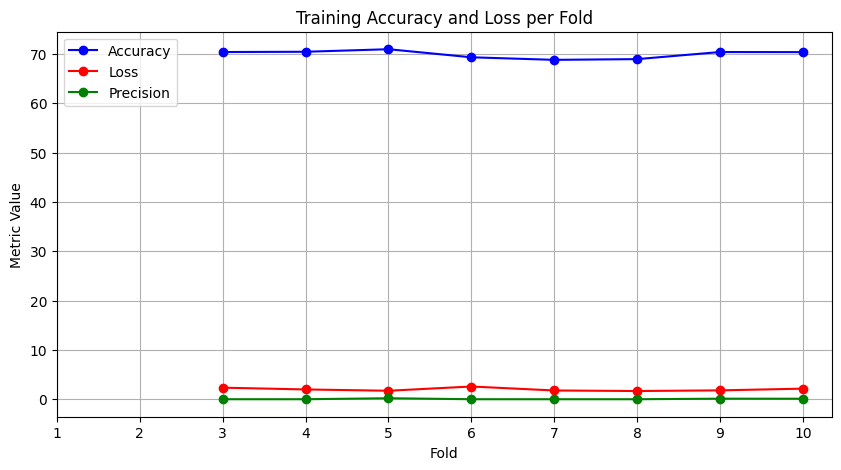

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss per fold in the same figure
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.plot(kfold_list, mean_acc_per_fold, marker='o', linestyle='-', color='b', label='Accuracy')

# Plot loss
plt.plot(kfold_list, mean_loss_per_fold, marker='o', linestyle='-', color='r', label='Loss')

# plot precision
plt.plot(kfold_list, mean_precision_per_fold,marker='o', linestyle='-', color='g', label='Precision')

plt.title('Training Accuracy and Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(range(1, num_folds + 1))
plt.grid(True)
plt.legend()
plt.show()
